Created by Eden Au <br>
Last Updated: 16 Feb 2021

## Liquidity mining constants

MINING_SECONDS: the period of the liquidity mining programme (in seconds) <br>
TOTAL_REWARD: total number of rewards to be distributed 

BASIC_RATE: the discount rate with no long-term staking bonus <br>
BONUS_SECONDS: the staking time necessary to reach maximum 'multiplier'



In [1]:
# Generic
MINING_SECONDS = 4*30*86400 # 4 months in seconds 
TOTAL_REWARD = 30e6 # 30mil ROWAN to be distributed

# Geyser specific
BASIC_RATE = .25
BONUS_SECONDS = 12*7*86400 # 12 weeks in seconds

# Bundling
constants = {'miningSeconds':MINING_SECONDS,
             'totalReward':TOTAL_REWARD,
             'basicRate':BASIC_RATE,
             'bonusSeconds':BONUS_SECONDS}

Assume 57,333,333 Rowan tokens provided as liquidity on Day 0

In [2]:
# Assumption
FIXED_TOTAL_STAKED = 57333333

## Standard liquidity mining APY calculator

In [3]:
def get_normal_APY(totalStaked, **kwargs):
    """
    args:
        totalStaked: global total liquidity staked (in ROWAN)
    kwargs:
        miningSeconds: the period of the liquidity mining programme (in seconds)
        totalReward: total number of rewards to be distributed
    returns:
        apy: marginal APY
    """
    miningSeconds, totalReward = kwargs['miningSeconds'], kwargs['totalReward']
    apy = totalReward \
        / totalStaked \
        * 365 * 86400 / miningSeconds \
        * 100
    return apy

In [4]:
# example using aforementioned assumption
normalApy = get_normal_APY(totalStaked=FIXED_TOTAL_STAKED, 
                           **constants)
print(f'Normal APY: {normalApy:.2f}%')

Normal APY: 159.16%


## Geyser liquidity mining APY calculator

The y-intercept is $1$ <br>
the $max(\cdot)$ is $\frac{1}{\text{BASIC_RATE}}$ at $t \geq \text{BONUS_SECONDS}$<br>

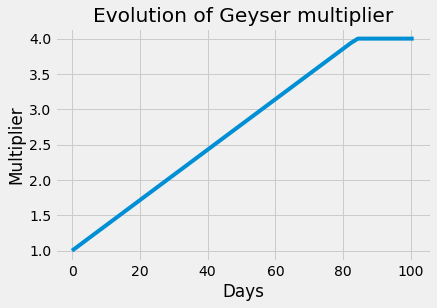

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

days = np.linspace(0,BONUS_SECONDS//86400*1.2)
rates = BASIC_RATE + (1-BASIC_RATE) * days / (BONUS_SECONDS//86400)
rates = [min(1,r)/BASIC_RATE for r in rates]

plt.plot(days, rates)
plt.title('Evolution of Geyser multiplier')
plt.xlabel('Days')
plt.ylabel('Multiplier')
plt.show()

In [6]:
def get_geyser_APY(totalStakedSeconds, secondsPassed, plannedStakingSeconds, **kwargs):
    """
    Geyser refers to Ampleforth geyser-style liquidity mining programme:
    https://github.com/ampleforth/token-geyser/blob/master/contracts/TokenGeyser.sol
    
    The earlier (unsaturated advantage) AND the longer (saturated advantage) you stake, the more % you earn
    args:
        totalStakedSeconds: global 'deposit-seconds'
        secondsPassed: time elapsed since liquidity mining started (in seconds)
        plannedStakingSeconds: how long does users intend to stake (in seconds)
    kwargs:
        miningSeconds: the period of the liquidity mining programme (in seconds)
        totalReward: total number of rewards to be distributed
        basicRate: the discount rate with no long-term staking bonus
        bonusSeconds: the staking time necessary to reach maximum 'multiplier'
    returns:
        apy: marginal APY
    """
    miningSeconds, totalReward, basicRate, bonusSeconds = kwargs['miningSeconds'], kwargs['totalReward'], kwargs['basicRate'], kwargs['bonusSeconds']
    
    # line 1. total reward
    # line 2: distributed pro-rata to stakedSeconds, assuming 
    #         no future staking/unstaking activities (common assumption)
    # line 3: normalised by the period to reach max bonus 
    # line 4: annualised
    # line 5: take into account 'multiplier' that incentivises long-term staking
    # line 6: convert to percentage
    apy = totalReward \
        / (totalStakedSeconds / secondsPassed * (secondsPassed+bonusSeconds)) \
        * bonusSeconds \
        * 365 * 86400 / miningSeconds \
        * min(1, basicRate + (1-basicRate) * plannedStakingSeconds / bonusSeconds) \
        * 100
    return apy

In [7]:
# examples using aforementioned assumption
# users start mining at different time
for secondsPassed in [1, 1*86400, 7*86400, 30*86400]:
    geyserApy = get_geyser_APY(totalStakedSeconds=FIXED_TOTAL_STAKED*secondsPassed, 
                               secondsPassed=secondsPassed,
                               plannedStakingSeconds=BONUS_SECONDS,
                               **constants) 
    print(f'Geyser APY: {geyserApy:.2f}%, {secondsPassed/86400:.0f} days after mining started, if users stake {BONUS_SECONDS/86400:.0f} days')

Geyser APY: 159.16%, 0 days after mining started, if users stake 84 days
Geyser APY: 157.28%, 1 days after mining started, if users stake 84 days
Geyser APY: 146.91%, 7 days after mining started, if users stake 84 days
Geyser APY: 117.27%, 30 days after mining started, if users stake 84 days


In [8]:
# examples using aforementioned assumption
# users stay mining for different periods
for plannedStakingSeconds in [0, BONUS_SECONDS//3, BONUS_SECONDS//3*2, BONUS_SECONDS]:
    geyserApy = get_geyser_APY(totalStakedSeconds=FIXED_TOTAL_STAKED*1, 
                               secondsPassed=1,
                               plannedStakingSeconds=plannedStakingSeconds,
                               **constants) 
    print(f'Geyser APY: {geyserApy:.2f}%, 0 days after mining started, if users stake {plannedStakingSeconds/86400:.0f} days')

Geyser APY: 39.79%, 0 days after mining started, if users stake 0 days
Geyser APY: 79.58%, 0 days after mining started, if users stake 28 days
Geyser APY: 119.37%, 0 days after mining started, if users stake 56 days
Geyser APY: 159.16%, 0 days after mining started, if users stake 84 days
